## Process CLAMS sleep/wake data from activity output file

CLAMS Comprehensive Lab Animal Monitoring System: Oxymax®-CLAMS

"Columbus Instruments Comprehensive Lab Animal Monitoring System CLAMS is the premiere system of its kind. Incorporating sub-systems for open circuit calorimetry, activity, body mass, feeding, drinking and sleep detection in an optional environmental chamber: Oxymax/CLAMS is the one-test solution for simultaneous multi parameter assessment of 1 to 32 test animals.

The Columbus Instruments Oxymax EConomy System is an indirect open circuit calorimeter designed to simultaneously measure metabolic performance of multiple subjects that have similar ventilation needs. The system monitors oxygen and carbon dioxide concentrations by volume at the inlet and outlet ports of a chamber, canopy, tent, or mask through which a known flow of air is being forcibly ventilated. The difference in gas concentrations along with flow information is employed to calculate oxygen consumption, carbon dioxide production, respiratory exchange ratio and heat. All data provided by the Oxymax EConomy is corrected to an STP of 0°C and 760 mmHg. The system presents data in normalized forms that are user-defined."

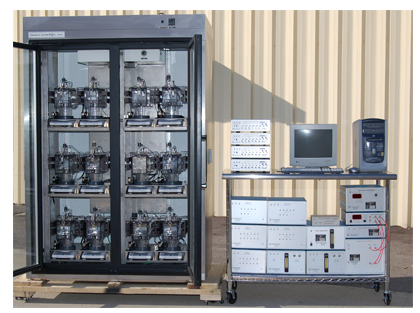

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Get paths for files and separate into data type (main, activity, or food)

In [2]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data'

dir_path_list = os.listdir(orig_path)

data_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    data_dir_paths.append(int_path)
    
data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_168d_AS#917-TCg1-6mo',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_112d_AS#917-TCg2-4m',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_7d_AS#917-TCexp-nov19',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_365d_AS#197-TCg1-12mo',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_252d_SA#917-TCg2-9m0',
 '/Users/abbieschindler/Documents/S

In [3]:
#create list of raw datafiles to be processed, we are interested in 3 file types, a general, an activity (A), and a food (B)

def get_file_lists(path):
    
    dir_list = os.listdir(path)
    
    gen_list = []
    activity_list = []
    food_list = []

    for directory in dir_list:
        
        if (len(directory.split('.')[1]) == 4) & (directory.split('.')[1][0] == '0'):
            int_path = path + '/' + directory
            gen_list.append(int_path)
        if directory.split('.')[1][0:2] == 'A0':
            int_path = path + '/' + directory
            activity_list.append(int_path)
        if directory.split('.')[1][0:2] == 'B0':
            int_path = path + '/' + directory
            food_list.append(int_path)
            
    return gen_list, activity_list, food_list

In [4]:
#use get_file_lists function to create final lists of paths

general_data_paths = []
activity_data_paths = []
food_data_paths = []
    
for data_dir in data_dir_paths:

    try:
        gen_list, activity_list, food_list = get_file_lists(data_dir)
        general_data_paths.extend(gen_list)
        activity_data_paths.extend(activity_list)
        food_data_paths.extend(food_list)
        
    except:
        print(data_dir)
    
print(len(general_data_paths))
print(len(activity_data_paths))
print(len(food_data_paths))

/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/.DS_Store
240
241
241


### Process sleep data files

#### Read in and combine into one df

In [5]:
gen_data_comb = pd.DataFrame()

for path in activity_data_paths:
    print(path)
    
    with open(path, 'r') as file:
        lns = file.readlines()
    
    data_lines = []

    for ln in lns:
        #print(ln)
        #get animal number
        if 'SUBJECT ID' in ln:
            animal_id = ln.split(':')[1].split('\n')[0]
        #put in pandas df
        if 'INTERVAL' in ln:
            col_list = ln.split(',')
        if re.search('^\s\d', ln.split(',')[0]):
            data_lines.append(ln.split(','))
        
    df = pd.DataFrame(data=data_lines, columns=col_list)

    #fill metadata
    df['cohort'] = path.split('/')[-2].split('_')[0]
    df['timepoint'] = path.split('/')[-2].split('_')[1]
    df['animal'] = animal_id
    #rearange columns 
    df = df[['cohort', 'timepoint', 'animal', 'DATE/TIME', 'INTERVAL', 'XTOT', 'XAMB']]
    df.columns = ['cohort', 'timepoint', 'animal', 'datetime', 'interval', 'XTOT', 'XAMB']
    #clean up and create intervals
    df['datetime'] = pd.to_datetime(df['datetime']).dt.round(freq='1min')
    df['date'] = df['datetime'].dt.date
    df['day'] = df['datetime'].dt.weekday + 1
    df['hour'] = df['datetime'].dt.hour
    df['min'] = df['datetime'].dt.minute
    #round time and create new column
    df['time'] = df['datetime'].dt.strftime('%H:%M')

    #add to final general data frame
    gen_data_comb = pd.concat([gen_data_comb, df], axis=0)
    
    print(gen_data_comb.shape)

print(gen_data_comb['animal'].value_counts())
gen_data_comb.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0107.CSV
(5787, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0113.CSV
(11574, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0112.CSV
(17361, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0106.CSV
(23148, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0110.CSV
(28935, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg1/2020-07-20.A0104.CSV
(34722, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_252d_AS#917-TCg

(318527, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m/2021-01-04.A0113.CSV
(324268, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m/2021-01-04.A0112.CSV
(330009, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m/2021-01-04.A0110.CSV
(335750, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m/2021-01-04.A0104.CSV
(341491, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_420d_AS#917-TCg1-15m/2021-01-04.A0111.CSV
(347232, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_7d_AS#917-TCexp-nov19/2019-11-18.A0106.CSV
(353008, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/

(628414, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0110.CSV
(634212, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0104.CSV
(640010, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0111.CSV
(645808, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0115.CSV
(651606, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0101.CSV
(657404, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_420d_AS#917-TCexp/2021-05-17.A0114.CSV
(663202, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw

(935573, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_504d_AS#917-TCg2-18mo/2021-08-10.A0101.CSV
(941310, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_504d_AS#917-TCg2-18mo/2021-08-10.A0115.CSV
(947047, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_504d_AS#917-TCg2-18mo/2021-08-10.A0114.CSV
(952784, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_504d_AS#917-TCg2-18mo/2021-08-10.A0108.CSV
(958521, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_504d_AS#917-TCg2-18mo/2021-08-10.A0109.CSV
(964258, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg1_28d_AS#917-TC#2-dec19/2019-12-09.A0101.CSV
(970088, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/C

(1243921, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0115.CSV
(1249762, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0101.CSV
(1255602, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0114.CSV
(1261443, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0110.CSV
(1267284, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0104.CSV
(1273124, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS/2020_timecourse/raw_data/TCg2_168d_AS#917-TCg2-6mo/2020-09-21.A0105.CSV
(1278965, 12)
/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/

,cohort,timepoint,animal,datetime,interval,XTOT,XAMB,date,day,hour,min,time
0,TCg1,252d,787,2020-07-20 12:02:00,1,1075,807,2020-07-20,1,12,2,12:02
1,TCg1,252d,787,2020-07-20 12:03:00,1,339,244,2020-07-20,1,12,3,12:03
2,TCg1,252d,787,2020-07-20 12:04:00,1,336,253,2020-07-20,1,12,4,12:04
3,TCg1,252d,787,2020-07-20 12:05:00,1,301,233,2020-07-20,1,12,5,12:05
4,TCg1,252d,787,2020-07-20 12:06:00,1,211,140,2020-07-20,1,12,6,12:06


#### Add light dark, hour and min counts, and clean

In [ ]:

def assign_ld(time):
    if (time > 5) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time > 17):
        return 'dark_pm'
    
gen_data_comb['ld_seg'] = gen_data_comb['hour'].apply(assign_ld)

#column of running hour and minute count
gen_data_comb['hour_count'] = (gen_data_comb['day']*24) + gen_data_comb['hour'] - 24
gen_data_comb['min_count'] = (gen_data_comb['hour_count']*60) + gen_data_comb['min'] - 60

#update dtype
gen_data_comb['XTOT'] = gen_data_comb['XTOT'].astype('float')
gen_data_comb['XAMB'] = gen_data_comb['XAMB'].astype('float')

print(gen_data_comb.shape)
print(gen_data_comb['timepoint'].value_counts())
gen_data_comb.head()

#### Add day/night mapping (lines up dates and ld segments)

In [ ]:
ld_mapping_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism//CLAMS/2020_timecourse/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

In [ ]:
gen_data_comb = gen_data_comb.merge(ld_mapping, on=['day', 'ld_seg'])
gen_data_comb.head()

#### Add meta data

In [ ]:
#read in and combine with animal meta data

meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Metabolism/CLAMS_final.xlsx'

meta = pd.read_excel(meta_path)
meta = pd.DataFrame(data = meta)
print(meta.shape)

#combine with final df 
gen_data_comb['animal'] = gen_data_comb['animal'].astype(int)
df_final = pd.merge(gen_data_comb, meta, on=['animal'], sort=False)

print(df_final.shape)
df_final.head()

### Compute sleep/wake stats

#### sleep vs wake for each minute time segment

In [ ]:
df_final['sw_0'] = ['wake' if x > 0 else 'sleep' for x in df_final['XAMB']]
df_final['sw_1'] = ['wake' if x > 1 else 'sleep' for x in df_final['XAMB']]
df_final['sw_2'] = ['wake' if x > 2 else 'sleep' for x in df_final['XAMB']]

df_final.head()

### Compute bout stats

#### sleep bout

In [ ]:
def sleep_bout(df, col):
    
    df_sleep_bout_function = pd.DataFrame()
    dic_sleep_bout_function = {}

    sleep_count = 0
    
    for index, row in df.iterrows():
    
        if row[col] == 'wake': #determine if current row is wake

            if sleep_count > 0: #determine if there is bin data to record (i.e., if previous row was sleep)
                dic_sleep_bout_function[datetime] = sleep_count #if bin data to record: add bin length to dict (datetime as key)
                sleep_count = 0 #reset sleep_count
            
        if row[col] == 'sleep': #determine if current row is sleep
            if sleep_count == 0: #determine if sleep_count is 0
                datetime = row['datetime'] #if sleep_count is zero: record the datetime of current row (start of sleep bout)
            sleep_count += 1 #if current row is sleep: add 1 to sleep_count
            if index == df.index[-1]: #determine if current row is last row of df   
                dic_sleep_bout_function[datetime] = sleep_count #if last row of df: add bin length to dict (datetime as key)
    
    df_sleep_bout_function = pd.DataFrame.from_dict(dic_sleep_bout_function, orient='index', columns=['bout_length']).reset_index()            
    df_sleep_bout_function['animal'] = df['animal'].values[0]
    df_sleep_bout_function['cohort'] = df['cohort'].values[0]
    df_sleep_bout_function['timepoint'] = df['timepoint'].values[0]
    df_sleep_bout_function['Group'] = df['Group'].values[0]
    
    return df_sleep_bout_function

In [ ]:
param = 'sw_0'

df_sleep_bout = pd.DataFrame()

#create df containing animal/timepoint unique matches
animal_timepoint_map = df_final.groupby(['animal', 'timepoint'])['timepoint'].count().reset_index(name='count')

for index, row in animal_timepoint_map.iterrows(): #use sleep_bout function on all animal/timepoint combos
    #select data for animal/timepoint
    data_int = df_final[(df_final['animal'] == row['animal']) & (df_final['timepoint'] == row['timepoint'])]
    #get sleep bout data
    df_sleep_bout_int = sleep_bout(data_int, param)
    
    #add to final df
    if df_sleep_bout.shape[0] == 0:
        df_sleep_bout = df_sleep_bout_int
    else:
        df_sleep_bout = pd.concat([df_sleep_bout, df_sleep_bout_int], axis=0)

In [ ]:
#clean up and create intervals
#df['datetime'] = pd.to_datetime(df['datetime']).dt.round(freq='1min')
df_sleep_bout['date'] = df_sleep_bout['index'].dt.date
df_sleep_bout['day'] = df_sleep_bout['index'].dt.weekday + 1
df_sleep_bout['hour'] = df_sleep_bout['index'].dt.hour
df_sleep_bout['time'] = df_sleep_bout['index'].dt.strftime('%H:%M')
#light dark
df_sleep_bout['ld_seg'] = df_sleep_bout['hour'].apply(assign_ld)
df_sleep_bout = df_sleep_bout.merge(ld_mapping, on=['day', 'ld_seg'])

df_sleep_bout.head()

### combine and drop acclimation period

In [ ]:
ld_drop = ['light_day1', 'dark_night1', 'light_day5', ]
df_sleep_bout_short = df_sleep_bout[~df_sleep_bout['ld'].isin(ld_drop)]

df_sleep_bout_short['ld_seg'] = [x.split('_')[0] for x in df_sleep_bout_short['ld']]
df_sleep_bout_short.head()

In [ ]:
#hour
sleep_total_hour = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'date',
                                          'ld_seg', 'ld', 'day', 'hour'])['bout_length'].sum().reset_index(name='sleep_total_hour')

sleepbout_mean_hour = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'date',
                                             'ld_seg', 'ld', 'day', 'hour'])['bout_length'].mean().reset_index(name='sleepbout_mean_hour')

sleepbout_count_hour = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'date',
                                              'ld_seg', 'ld', 'day', 'hour'])['bout_length'].count().reset_index(name='sleepbout_count_hour')

#ld
sleep_total_ld = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'ld_seg',
                                        'ld'])['bout_length'].sum().reset_index(name='sleep_total_ld')

sleepbout_mean_ld = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'ld_seg',
                                           'ld'])['bout_length'].mean().reset_index(name='sleepbout_mean_ld')

sleepbout_count_ld = df_sleep_bout_short.groupby(['animal', 'cohort', 'timepoint', 'Group', 'ld_seg',
                                            'ld'])['bout_length'].count().reset_index(name='sleepbout_count_ld')

### ld viz

In [ ]:
param = 'sw_0'

groupbys = ['cohort', 'timepoint', 'animal', 'Group', 'ld_seg', 'ld']

df_sw0_percent_ld = (df_final.groupby(groupbys)[param].value_counts()/df_final.groupby(groupbys)[param].count()*100).reset_index(name='percent_sleep') 
df_sw0_percent_ld = df_sw0_percent_ld[df_sw0_percent_ld[param] == 'sleep']
df_sw0_percent_ld['ld_seg'] = [x.split('_')[0] for x in df_sw0_percent_ld['ld']]

print(df_sw0_percent_ld.shape)
df_sw0_percent_ld.head()

In [ ]:
df_sw0_percent_ld = df_sw0_percent_ld.merge(sleep_total_ld, on=['animal', 'cohort', 'timepoint', 'Group', 'ld_seg', 'ld'])
df_sw0_percent_ld = df_sw0_percent_ld.merge(sleepbout_mean_ld, on=['animal', 'cohort', 'timepoint', 'Group', 'ld_seg', 'ld'])
df_sw0_percent_ld = df_sw0_percent_ld.merge(sleepbout_count_ld, on=['animal', 'cohort', 'timepoint', 'Group', 'ld_seg', 'ld'])

print(df_sw0_percent_ld.shape)
df_sw0_percent_ld.head()

In [ ]:
animals_keep = [773, 774, 775, 777, 778, 779, 780, 782, 807, 808, 809, 858, 859,
       860, 861, 862, 863, 864, 868, 870, 871, 872, 873, 874, 875]

df_sw0_percent_ld_final = df_sw0_percent_ld[df_sw0_percent_ld['animal'].isin(animals_keep)]

print(df_sw0_percent_ld_final.shape)
print(df_sw0_percent_ld_final.shape)

In [ ]:
df_sw0_percent_ld_final = df_sw0_percent_ld_final.groupby(['animal', 'cohort', 'timepoint', 'Group', 'ld_seg']).mean().reset_index()
df_sw0_percent_ld_final.head()

In [ ]:
order = ['7d', '28d', '112d', '168d', '252d', '365d', '420d', '504d']

sns.catplot(x='ld_seg', y='sleepbout_count_ld', data=df_sw0_percent_ld_final, kind='bar', hue='Group', 
            height=5, aspect=1, ci=68, col='timepoint', col_wrap=4, col_order=order)

In [ ]:
df_ld_short_mean_dark = df_sw0_percent_ld_final[df_sw0_percent_ld_final['ld_seg'] == 'dark'].sort_values(['timepoint', 'animal'])
df_ld_short_mean_light = df_sw0_percent_ld_final[df_sw0_percent_ld_final['ld_seg'] == 'light'].sort_values(['timepoint', 'animal'])

df_ld_short_mean_light['perc_sleep_ratio'] = df_ld_short_mean_dark['percent_sleep'].values / df_ld_short_mean_light['percent_sleep'].values
df_ld_short_mean_light['sleep_total_ratio'] = df_ld_short_mean_dark['sleep_total_ld'].values / df_ld_short_mean_light['sleep_total_ld'].values
df_ld_short_mean_light['sleepbout_mean_ratio'] = df_ld_short_mean_dark['sleepbout_mean_ld'].values / df_ld_short_mean_light['sleepbout_mean_ld'].values
df_ld_short_mean_light['sleepbout_count_ratio'] = df_ld_short_mean_dark['sleepbout_count_ld'].values / df_ld_short_mean_light['sleepbout_count_ld'].values

In [ ]:
df_ld_short_mean_light

In [ ]:
order = ['7d', '28d', '112d', '168d', '252d', '365d', '420d', '504d']

sns.catplot(x='ld_seg', y='perc_sleep_ratio', data=df_ld_short_mean_light, kind='bar', hue='Group', 
            height=5, aspect=1, ci=68, col='timepoint', col_wrap=4, col_order=order)

#### Viz

In [ ]:
order = ['7d', '28d', '112d', '168d', '252d', '365d', '420d', '504d']

sns.catplot(x='ld_seg', y='sleepbout_count_ratio', data=df_ld_short_mean_light, kind='bar', hue='Group', 
            height=5, aspect=1, ci=68, col='timepoint', col_wrap=4, col_order=order)

#### combine and drop acclimation period hour

In [ ]:
param = 'sw_0'

groupbys = ['cohort', 'timepoint', 'animal', 'Group', 'ld_seg', 'ld',
            'day', 'hour', 'hour_count']
df_sw0_percent_hour = (df_final.groupby(groupbys)[param].value_counts()/df_final.groupby(groupbys)[param].count()*100).reset_index(name='percent_sleep') 
df_sw0_percent_hour = df_sw0_percent_hour[df_sw0_percent_hour[param] == 'sleep']

In [ ]:
df_sw0_percent_hour = df_sw0_percent_hour.merge(sleep_total_hour, on=['animal', 'cohort', 'timepoint', 'Group', 'day', 'hour'])
df_sw0_percent_hour = df_sw0_percent_hour.merge(sleepbout_mean_hour, on=['animal', 'cohort', 'timepoint', 'Group', 'day', 'hour'])
df_sw0_percent_hour = df_sw0_percent_hour.merge(sleepbout_count_hour, on=['animal', 'cohort', 'timepoint', 'Group', 'day', 'hour'])

df_sw0_percent_hour.head()

In [ ]:
df_hour_short = df_sw0_percent_hour[(df_sw0_percent_hour['day'] > 2)]
#drop first part of day 3
df_hour_short = df_sw0_percent_hour[~((df_sw0_percent_hour['day'] == 3) & (df_sw0_percent_hour['hour'] < 6))]
#drop last part of day 5
df_hour_short = df_sw0_percent_hour[~((df_sw0_percent_hour['day'] == 5) & (df_sw0_percent_hour['hour'] > 5))]
df_hour_short.head()

In [ ]:
order = ['7d', '28d', '112d', '168d', '252d', '365d', '420d', '504d']

sns.catplot(x='hour', y='sleepbout_count_hour_y', data=df_hour_short, kind='bar', hue='Group', 
            height=5, aspect=2, ci=68, col='timepoint', col_wrap=1, col_order=order)

In [ ]:
df_ld_short

In [ ]:
df_ld_short_mean_light

In [ ]:
df_ld_short_final

In [ ]:
df_ld_short_final.set_index(['cohort', 'timepoint', 'animal', 'Group', 'ld_seg']).unstack(level=1)

In [ ]:
df_ld_short_mean_light.to_csv('df_ld_short_mean_light.csv')